In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure3_modalities_functional'

import flotilla

study = flotilla.embark('singlecell_pnm_figure2_modalities')
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))


2015-09-29 17:50:51	Reading datapackage from /home/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities/datapackage.json
2015-09-29 17:50:51	Parsing datapackage to create a Study object
2015-09-29 17:51:53	Initializing Study
2015-09-29 17:51:53	Initializing Predictor configuration manager for Study
2015-09-29 17:51:53	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-09-29 17:51:53	Added ExtraTreesClassifier to default predictors
2015-09-29 17:51:53	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-09-29 17:51:53	Added ExtraTreesRegressor to default predictors
2015-09-29 17:51:53	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-09-29 17:51:53	Added GradientBoostingClassifier to default predictors
2015-09-29 17:51:53	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boost

### Enrichment of this modality, within phenotype

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to other modalities in iPSC?"*

In [3]:
study.splicing.feature_expression_id_col = 'ensembl_id'

MN
	bimodal
	~0
	~1
NPC
	bimodal
	~0
	~1
iPSC
	bimodal
	multimodal
	~0
	~1


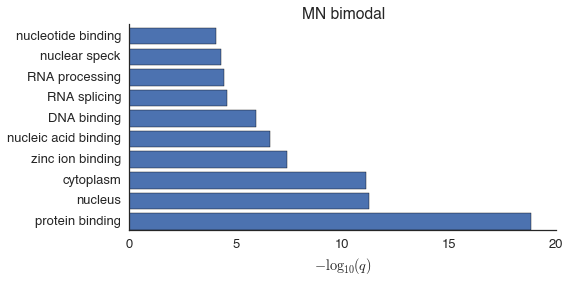

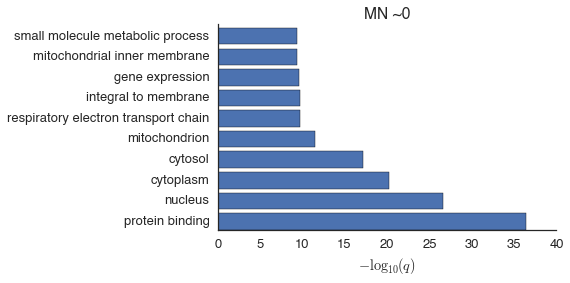

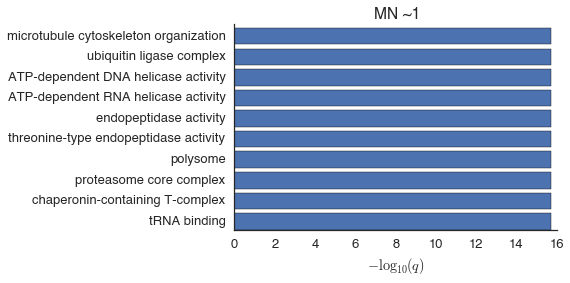

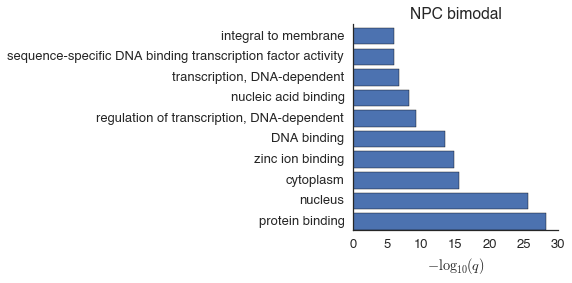

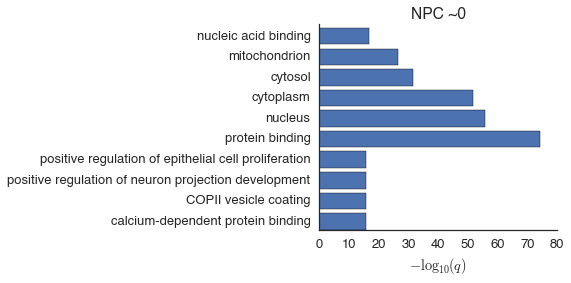

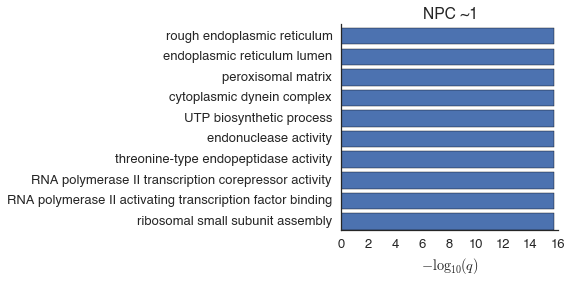

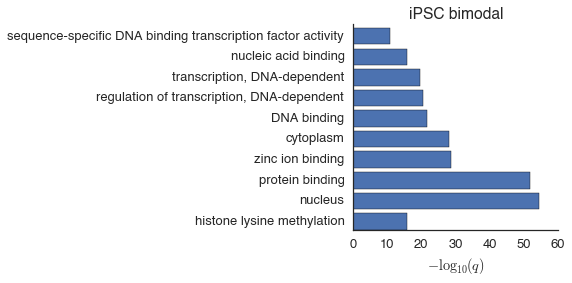

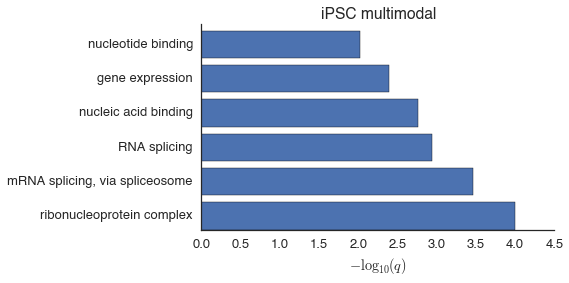

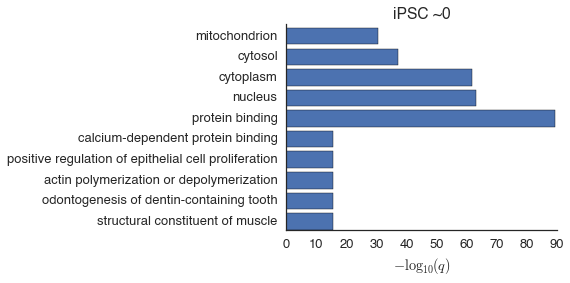

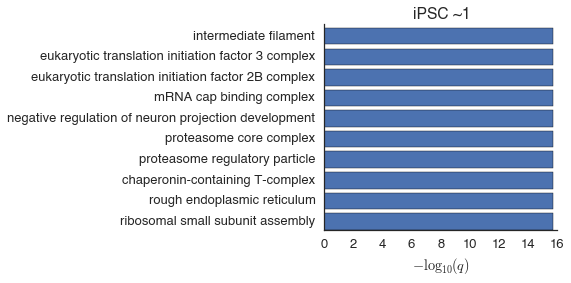

In [4]:
from flotilla.visualize.gene_ontology import plot_go_enrichment

for (phenotype), phenotype_df in study.supplemental.modalities_tidy.groupby(['phenotype']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_name)
    for modality, modality_df in phenotype_df.groupby('modality'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_name)
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01)
        if go is None or go.empty:
            print '... empty GO enrichment!'
            continue
        fig, ax = plt.subplots(figsize=(8, 4))
        ax = plot_go_enrichment(data=go)
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
        fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_within_celltype_{}_{}.pdf'.format(folder, modality, phenotype))

### Enrichment of this modality, across phenotypes

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to bimodal events in NPC and MN?"*

bimodal
	MN
	NPC
	iPSC
multimodal
	iPSC
~0
	MN
	NPC
	iPSC
~1
	MN
	NPC
	iPSC


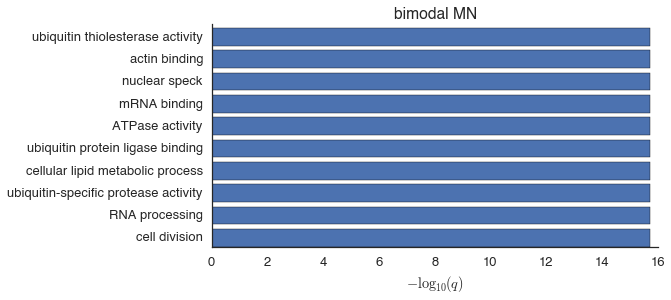

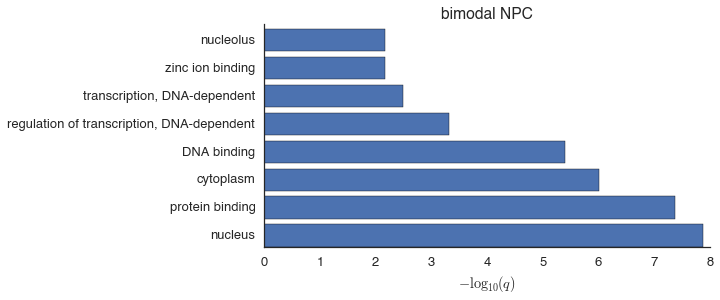

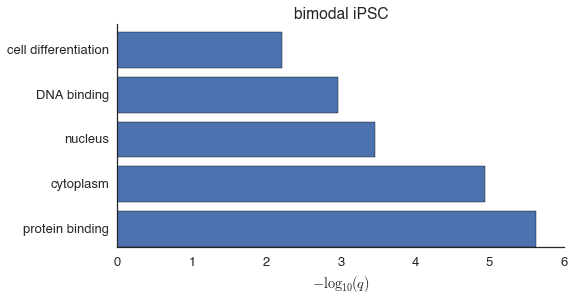

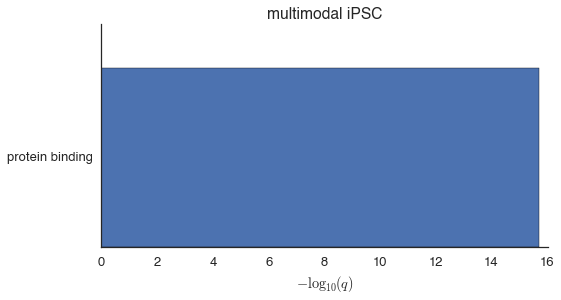

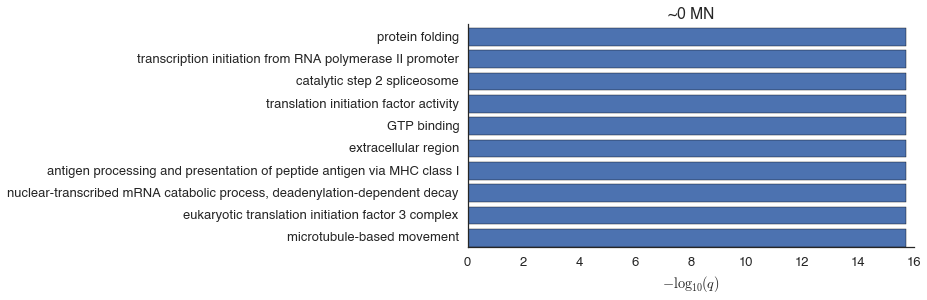

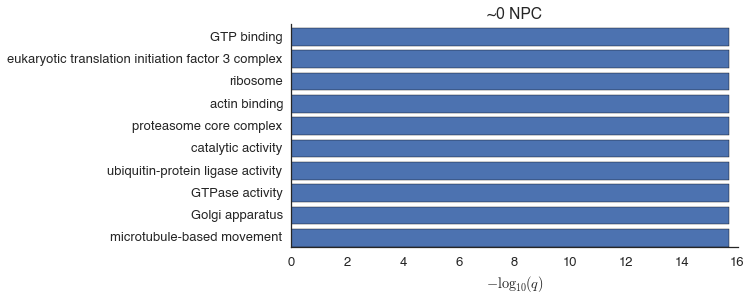

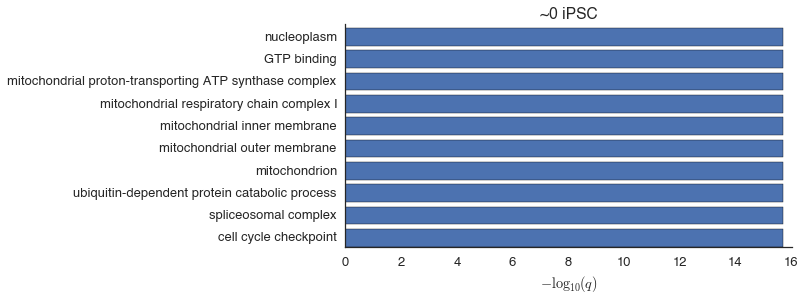

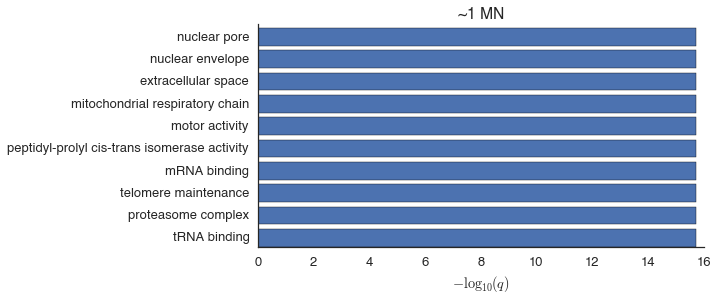

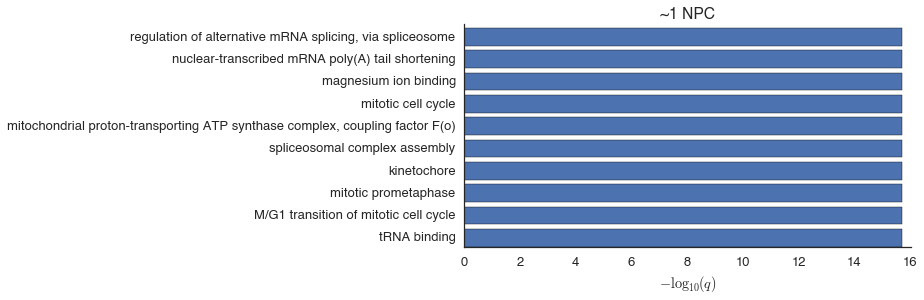

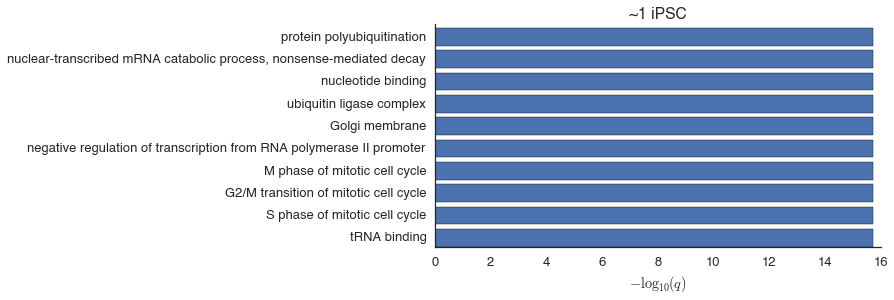

In [12]:
import itertools

modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_name').filter(
    lambda x: len(x)==len(study.phenotype_order))

go_dfs = []

for (phenotype), phenotype_df in modalities_all_celltypes.groupby(['modality']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_name)
    for modality, modality_df in phenotype_df.groupby('phenotype'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_name)
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01)
        if go is None or go.empty:
            print '\t... empty GO enrichment!'
            continue
            
        go['modality'] = modality
        go['phenotype'] = phenotype
        go_dfs.append(go.reset_index())
        fig, ax = plt.subplots(figsize=(8, 4))
        ax = plot_go_enrichment(data=go)
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_across_celltypes_{}_{}.pdf'.format(folder, modality, phenotype))
go_df = pd.concat(go_dfs, ignore_index=True)

In [6]:
MACHINE_EPSILON = np.finfo(float).eps

In [7]:
MACHINE_EPSILON

2.2204460492503131e-16

In [10]:
min(MACHINE_EPSILON, go.bonferonni_corrected_p_value.replace(0, np.nan).min())

1.4302299188963691e-287